<a href="https://colab.research.google.com/github/Park-hanna/BDA_study/blob/main/Forecasting/%EC%9E%90%EB%8F%99%EC%B0%A8_%EC%A0%9C%EC%A1%B0_%ED%85%8C%EC%8A%A4%ED%8A%B8_%EA%B3%B5%EC%A0%95_%EC%8B%9C%EA%B0%84_%EC%98%88%EC%B8%A1%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations

import seaborn as sns
from sklearn import preprocessing
import xgboost as xgb
from sklearn.base import BaseEstimator,TransformerMixin,ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import FeatureAgglomeration

from sklearn.random_projection import GaussianRandomProjection
from sklearn.random_projection import SparseRandomProjection
from sklearn.linear_model import ElasticNetCV, LassoLarsCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline, make_union
from sklearn.utils import check_array
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import SelectFromModel

seed = 40

import warnings
warnings.filterwarnings('ignore')
color = sns.color_palette()
%matplotlib inline

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Data/mercedes-benz-greener-manufacturing/train.csv')
test_df = pd.read_csv('/content/drive/MyDrive/Data/mercedes-benz-greener-manufacturing/test.csv')

print('Train shape : ', train_df.shape)
print('Test shape : ', test_df.shape)

Train shape :  (4209, 378)
Test shape :  (4209, 377)


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4209 entries, 0 to 4208
Columns: 378 entries, ID to X385
dtypes: float64(1), int64(369), object(8)
memory usage: 12.1+ MB


In [ ]:
train_df.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


# Feature Data
1. ID
2. y : Target Feature : time
3. X0 - X385 : test

# Target Data
scatter plot

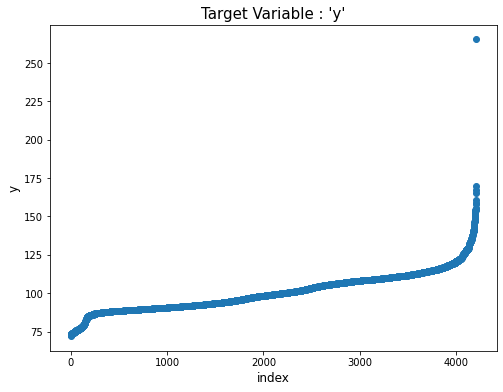

In [ ]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.y.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('y', fontsize = 12)
plt.title("Target Variable : 'y'", fontsize= 15)
plt.show()

histogram

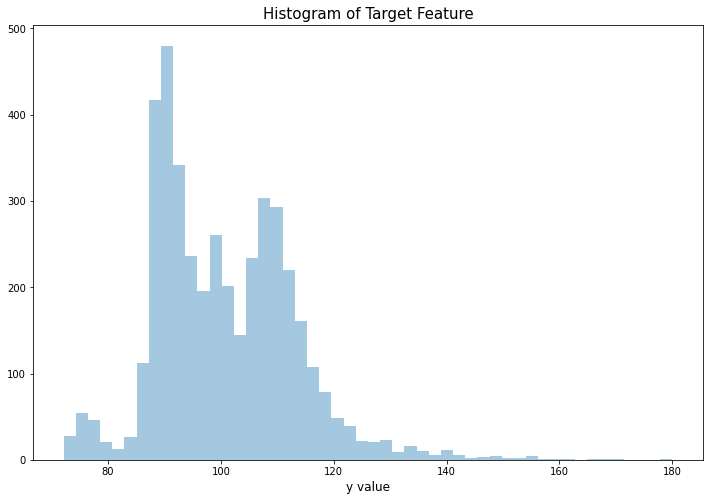

In [ ]:
ulimit = 180
train_df['y'].loc[train_df['y']>ulimit] = ulimit

plt.figure(figsize=(12,8))
sns.distplot(train_df.y.values, bins=50, kde=False)
plt.xlabel('y value', fontsize = 12)
plt.title('Histogram of Target Feature', fontsize=15)
plt.show()

In [ ]:
print('Min : {} - Max : {} - Mean : {} - Std : {}'.format(min(train_df['y'].values), max(train_df['y'].values), train_df['y'].values.mean(), train_df['y'].values.std()))
print('Numbers Grater than 180 : {}'.format(np.sum(train_df['y'].values > 180)))

Min : 72.11 - Max : 180.0 - Mean : 100.64904727963888 - Std : 12.481281731120474
Numbers Grater than 180 : 0


# Data Explore

In [ ]:
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ['Count', 'Column Type']
dtype_df.groupby('Column Type').aggregate('count').reset_index()

,Column Type,Count
0,int64,369
1,float64,1
2,object,8


In [ ]:
dtype_df.loc[:10, :]

,Count,Column Type
0,ID,int64
1,y,float64
2,X0,object
3,X1,object
4,X2,object
5,X3,object
6,X4,object
7,X5,object
8,X6,object
9,X8,object


# Missing Values

In [ ]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['Column_name', 'missing_count']
missing_df = missing_df.loc[missing_df['missing_count']>0]
missing_df = missing_df.sort_values(by='missing_count')
missing_df

,Column_name,missing_count


In [ ]:
cols = [c for c in train_df.columns if 'X' in c]
print('Number of features : {}'.format(len(cols)))
print('Feature typed : ')
train_df[cols].dtypes.value_counts()

Number of features : 376
Feature typed : 


int64     368
object      8
dtype: int64

In [ ]:
counts = [[], [], []]
for c in cols:
  typ = train_df[c].dtype
  uniq = len(np.unique(train_df[c]))
  if uniq == 1:
    counts[0].append(c)
  elif uniq == 2 and typ == np.int64:
    counts[1].append(c)
  else:
    counts[2].append(c)

print('If the Feature value is 1 : {} / If the Feature value is 2 : {} / If Categorical : {}\n'.format(*[len(c) for c in counts]))

print('If the Featrue value is 1 : ', counts[0])
print('If the Feature value is 2 : ', counts[1])

If the Feature value is 1 : 12 / If the Feature value is 2 : 356 / If Categorical : 8

If the Featrue value is 1 :  ['X11', 'X93', 'X107', 'X233', 'X235', 'X268', 'X289', 'X290', 'X293', 'X297', 'X330', 'X347']
If the Feature value is 2 :  ['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120

In [ ]:
unique_values_dict = {}
for col in train_df.columns:
  if col not in ["ID", "y", "X0", "X1","X2", "X3", "X4", "X5", "X6", "X8"]:
    unique_value = str(np.sort(train_df[col].unique()).tolist())
    tlist = unique_values_dict.get(unique_value, [])
    tlist.append(col)
    unique_values_dict[unique_value] = tlist[:]
for unique_val, columns in unique_values_dict.items():
  print("Unique Values that exist in the column : ", unique_val)
  print(columns)
  print('-'*60)

Unique Values that exist in the column :  [0, 1]
['X10', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 'X138', 'X139', 'X140', 'X141', 'X142', 'X143', 'X144', 'X14

# Categorical Features

In [ ]:
cat_feat = counts[2]
train_df[cat_feat].head()

,X0,X1,X2,X3,X4,X5,X6,X8
0,k,v,at,a,d,u,j,o
1,k,t,av,e,d,y,l,o
2,az,w,n,c,d,x,j,x
3,az,t,n,f,d,x,l,e
4,az,v,n,f,d,h,d,n


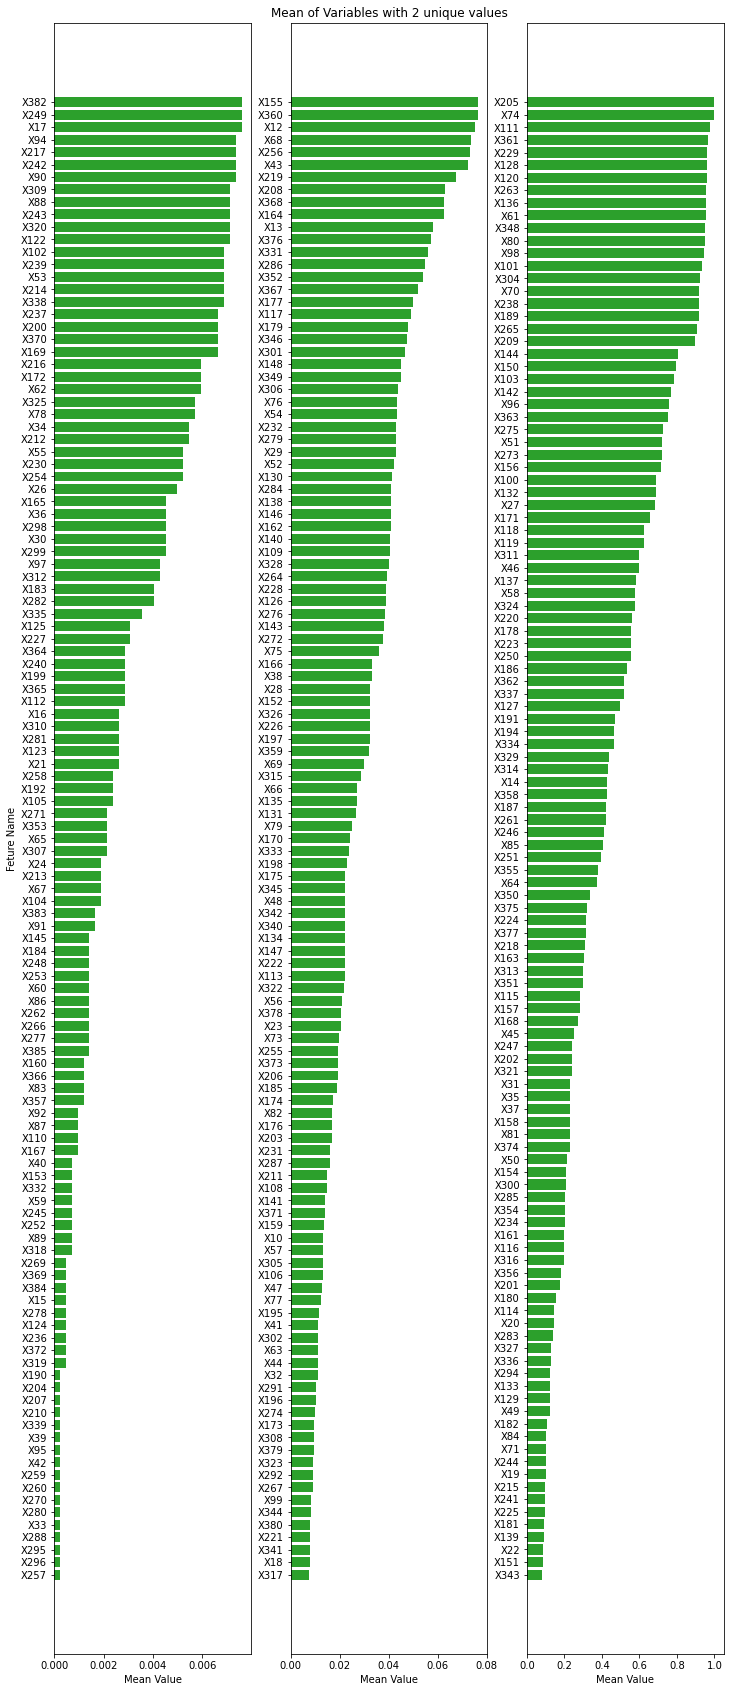

In [ ]:
binary_means = [np.mean(train_df[c]) for c in counts[1]]
binary_names = np.array(counts[1])[np.argsort(binary_means)]
binary_means = np.sort(binary_means)

fig, ax = plt.subplots(1,3, figsize=(12,30))
ax[0].set_ylabel('Feture Name')
ax[1].set_title('Mean of Variables with 2 unique values')
for i in range(3):
  names, means = binary_names[i*119:(i+1)*119], binary_means[i*119:(i+1)*119]
  ax[i].barh(range(len(means)), means, color=color[2])
  ax[i].set_xlabel('Mean Value')
  ax[i].set_yticks(range(len(means)))
  ax[i].set_yticklabels(names, rotation='horizontal')
plt.show()

# Machine Learning Modeling

## Baseline Model 1 : xgboost model

### Label Encoding

In [ ]:
for f in ['X0', 'X1', 'X2','X3', 'X4', 'X5', 'X6', 'X8']:
  lbl = preprocessing.LabelEncoder()
  lbl.fit(list(train_df[f].values))
  train_df[f] = lbl.transform(list(train_df[f].values))

### Data Preparation


In [ ]:
train_y = train_df['y'].values
train_x = train_df.drop(['ID','y'], axis = 1)

### Create a Model

In [ ]:
def xgb_r2_score(preds, dtrain):
  labels = dtrain.get_label()
  return 'r2', r2_score(labels, preds)

xgb_params = {
    'eta' : 0.05,
    'max_depth' : 6,
    'subsample' : 0.7,
    'colsample_bytree' : 0.7,
    'objective' : 'reg:linear',
    'silent' : 1
}
dtrain = xgb.DMatrix(train_x, train_y, feature_names = train_x.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100, feval=xgb_r2_score, maximize= True)

[06:46:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Feature Importance

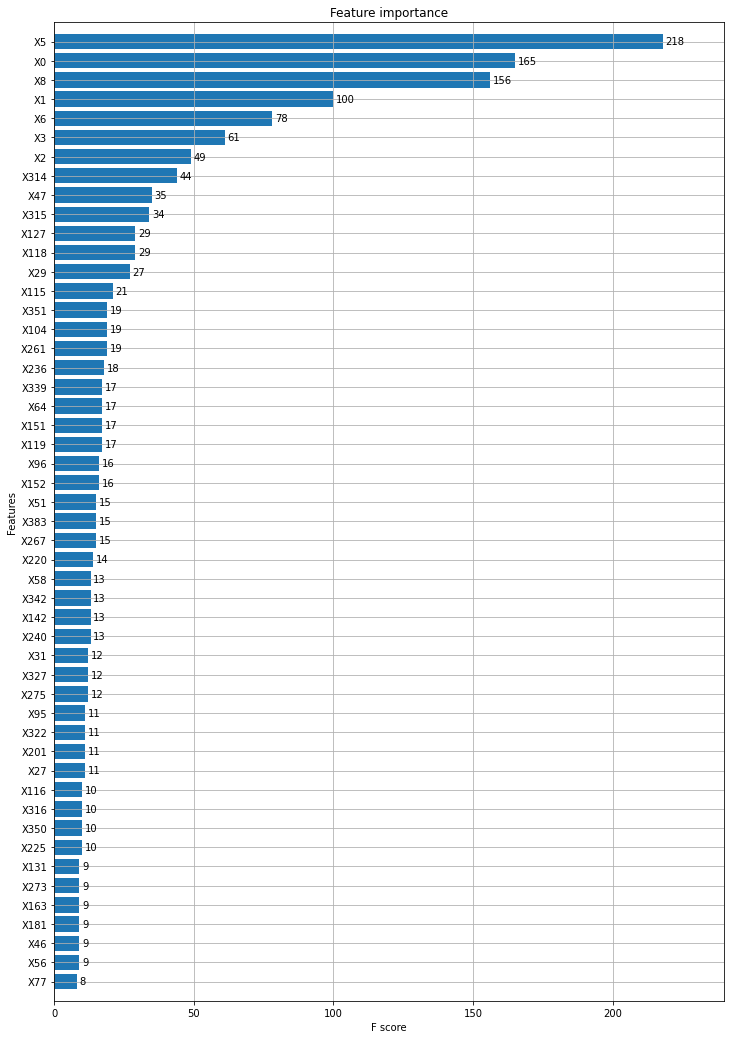

In [ ]:
fig ,ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features = 50, height = 0.8, ax = ax)
plt.show()

## Baseline Model 2 : Random Forest Model

### Create a Model

In [ ]:
from sklearn import ensemble
model = ensemble.RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_leaf=4, max_features=0.2, n_jobs=-1, random_state=0)
model.fit(train_x, train_y)

RandomForestRegressor(max_depth=10, max_features=0.2, min_samples_leaf=4,
                      n_estimators=200, n_jobs=-1, random_state=0)

### Feature Importances

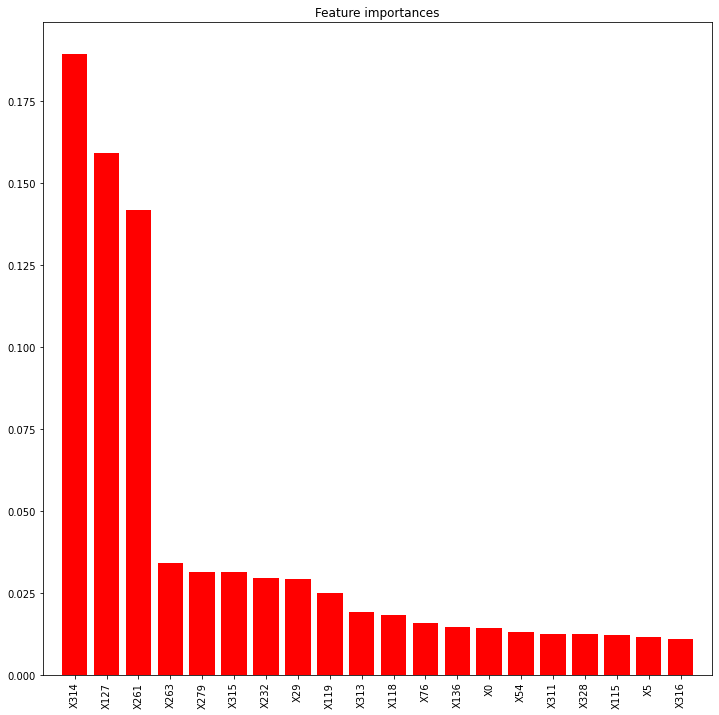

In [ ]:
feat_names = train_x.columns.values
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
indices = np.argsort(importances)[::-1][:20]

plt.figure(figsize=(12,12))
plt.title('Feature importances')
plt.bar(range(len(indices)), importances[indices], color='r', align = 'center')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.show()

# Feature selecting using various dimension reduction techniques

## General Application

### Types of Dimensionality Reduction Techniques
* Principal Component Analysis [PCA]
* Independent Component Analysis [ICA]
* Truncated SVD [TSVD]
* Gaussian Random Projection [GRP]
* Sparse Random Projection [SRP]
* Non-negative Matrix Factorization [NMF]
* Feature Agglomeration [FAG]

### Data Prerparation

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Data/mercedes-benz-greener-manufacturing/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Data/mercedes-benz-greener-manufacturing/test.csv')

y_train = train['y']
train = train.drop('y', axis=1)

### Label Encoding

In [ ]:
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(train[c].values) + list(test[c].values))
        train[c] = lbl.transform(list(train[c].values))
        test[c] = lbl.transform(list(test[c].values))

### Apply dimensionality reduction method

In [ ]:
n_comp = 12

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train)
tsvd_results_test = tsvd.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train)
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train)
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train)
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=420)
srp_results_train = srp.fit_transform(train)
srp_results_test = srp.transform(test)

# NMF
nmf = NMF(n_components=n_comp, init='nndsvdar', random_state=420)
nmf_results_train = nmf.fit_transform(train)
nmf_results_test = nmf.transform(test)

# FAG
fag = FeatureAgglomeration(n_clusters=n_comp, linkage='ward')
fag_results_train = fag.fit_transform(train)
fag_results_test = fag.transform(test)

In [ ]:
dim_reds = list()
train_pca = pd.DataFrame()
test_pca = pd.DataFrame()

train_ica = pd.DataFrame()
test_ica = pd.DataFrame()

train_tsvd = pd.DataFrame()
test_tsvd = pd.DataFrame()

train_grp = pd.DataFrame()
test_grp = pd.DataFrame()

train_srp = pd.DataFrame()
test_srp = pd.DataFrame()

train_nmf = pd.DataFrame()
test_nmf = pd.DataFrame()

train_fag = pd.DataFrame()
test_fag = pd.DataFrame()

for i in range(1, n_comp + 1):
  train_pca['pca_' + str(i)] = pca2_results_train[:, i-1]
  test_pca['pca_' + str(i)] = pca2_results_test[:, i-1]

  train_ica['ica_' + str(i)] = ica2_results_train[:, i-1]
  test_ica['ica_' + str(i)] = ica2_results_test[:, i-1]

  train_tsvd['tsvd_' + str(i)] = tsvd_results_train[:, i-1]
  test_tsvd['tsvd_' + str(i)] = tsvd_results_test[:, i-1]

  train_grp['grp_' + str(i)] = grp_results_train[:, i-1]
  test_grp['grp_' + str(i)] = grp_results_test[:, i-1]

  train_srp['srp_' + str(i)] = srp_results_train[:, i-1]
  test_srp['srp_' + str(i)] = srp_results_test[:, i-1]

  train_nmf['nmf_' + str(i)] = nmf_results_train[:, i-1]
  test_nmf['nmf_' + str(i)] = nmf_results_test[:, i-1]

  train_fag['fag_' + str(i)] = fag_results_train[:, i-1]
  test_fag['fag_' + str(i)] = fag_results_test[:, i-1]

dim_reds.append(('pca', train_pca, test_pca))
dim_reds.append(('ica', train_ica, test_ica))
dim_reds.append(('tsvd', train_tsvd, test_tsvd))
dim_reds.append(('grp', train_grp, test_grp))
dim_reds.append(('srp', train_srp, test_srp))
dim_reds.append(('nmf', train_nmf, test_nmf))
dim_reds.append(('fag', train_fag, test_fag))

## Performance experiment according to the application of multiple dimensionality reduction techniques

In [ ]:
combs = [combinations(dim_reds, i+1) for i in range(0, len(dim_reds))]

In [ ]:
dr_scores = list()
for c1 in combs:
    for c2 in c1:
        train_, test_, id_ = list(), list(), list()
        for k in c2:
            train_.append(k[1])
            test_.append(k[2])
            id_.append(k[0])

        train_x = train.reset_index(drop=True)
        train_.append(train_x)
        test_.append(test)

        train_ = pd.concat(train_, axis=1)
        test_ = pd.concat(test_, axis=1)


#============================ DecisionTree Model =======================
        model = DecisionTreeRegressor(max_depth=3, min_samples_split=11, presort=False, random_state=1729)
        model.fit(train_, y_train)
        c_score = r2_score(y_train, model.predict(train_))

#============================ ElasticNet model =======================
        model = ElasticNet(alpha=0.014, tol=0.11, l1_ratio=0.99999999,
                           normalize=True, fit_intercept=False, warm_start=True,
                          copy_X=True, precompute=False, positive=False, max_iter=60)
        model.fit(train_, y_train)
        c_score = r2_score(y_train, model.predict(train_))

#============================ Ridge model =============================
        model = Ridge()
        model.fit(train_, y_train)
        c_score = r2_score(y_train, model.predict(train_))

#================================ lightgbm model =======================
        lgb_params = {
        'num_iterations': 200,
        'learning_rate': 0.045,
        'max_depth': 3,
        'bagging_fraction': 0.93,
        'metric': 'l2_root',
        }

        dtrain = lgb.Dataset(train_, y_train)
        num_round = 1200
        model = lgb.train(lgb_params, dtrain, num_round)
        c_score = r2_score(y_train, model.predict(train_))

#================================= xgboost model ============================
        xgb_params = {
        'n_trees': 520,
        'eta': 0.0045,
        'max_depth': 4,
        'subsample': 0.93,
        'objective': 'reg:linear',
        'eval_metric': 'rmse',
        'base_score': np.mean(y_train),
        }

        dtrain = xgb.DMatrix(train_, y_train)

        num_boost_rounds = 1250
        model = xgb.train(xgb_params, dtrain, num_boost_round=num_boost_rounds)
        c_score = r2_score(y_train, model.predict(dtrain))

        dr_scores.append((','.join(id_), c_score))

In [ ]:
# baseline scoring for comparision

model = ElasticNet(alpha=0.014, tol = 0.11, l1_ratio = 0.99999999,
                   normalize = True, fit_intercept = False, warm_start = True,
                   copy_X = True, precompute = False, positive = False, max_iter = 60)

model.fit(train, y_train)
full_score = r2_score(y_train, model.predict(train))

dr_scores.append(('baseline', full_score))


### ploting the graph
please open the plots in a separate tab for better labels and clarity

In [ ]:
for dr_score in dr_scores:
  if dr_score[1] < 0:
    dr_score = (dr_score[0],0)

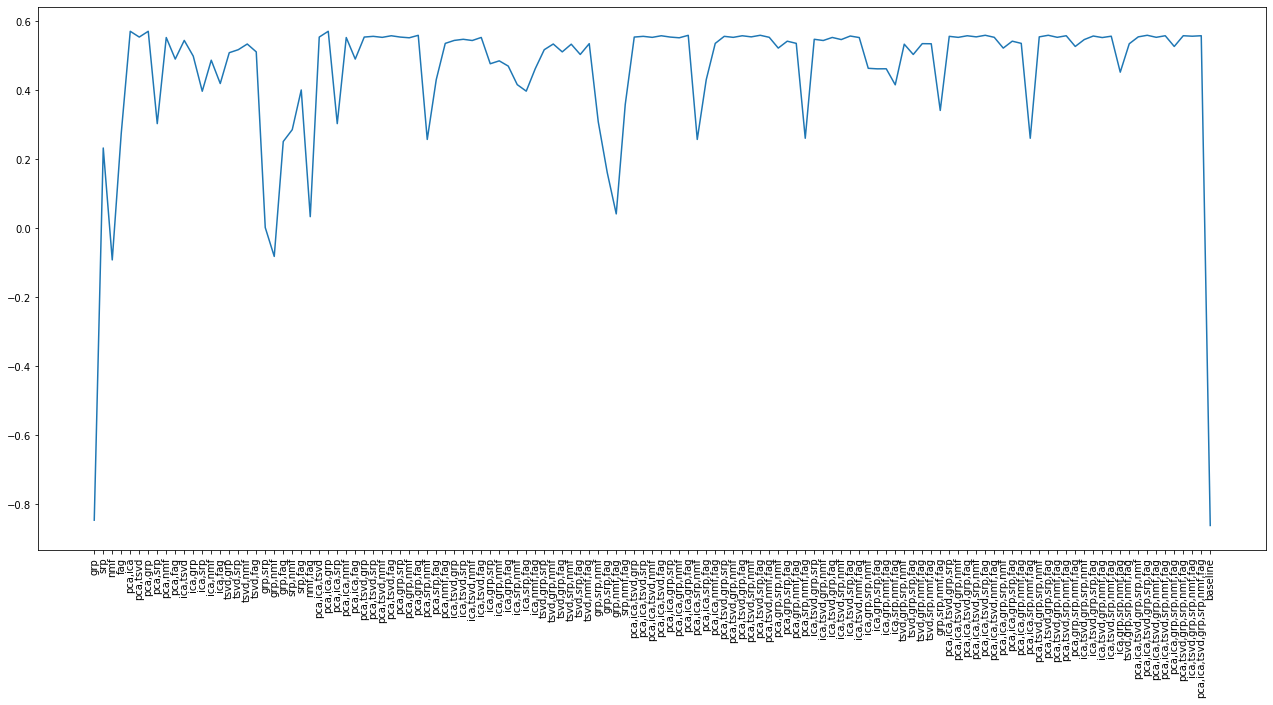

In [ ]:
x_axis = [c[0] for c in dr_scores]
y_axis = [c[1] for c in dr_scores]
fig, ax = plt.subplots(figsize=(22, 10))
plt.plot(y_axis)
ax.set_xticks(range(len(x_axis)))
ax.set_xticklabels(x_axis, rotation='vertical')
plt.show()

## Comparison of model preformance

In [ ]:
sorted_id = np.argsort(y_axis)
print('Combination of score lower 7 dimension reduction techniques : {}'.format(np.array(x_axis)[sorted_id[:7]]))
print('Combination of score higher 7 dimension reduction techniques : {}'.format(np.array(x_axis)[sorted_id[-7:]]))

print('\n\n Combination with the highest score : {}'.format(np.array(x_axis)[sorted_id[-1]]))

Combination of score lower 7 dimension reduction techniques : ['baseline' 'grp' 'nmf' 'grp,nmf' 'grp,srp' 'nmf,fag' 'grp,nmf,fag']
Combination of score higher 7 dimension reduction techniques : ['pca,tsvd,srp,fag' 'pca,ica,tsvd,srp,fag' 'pca,ica,tsvd,grp,srp,fag'
 'pca,tsvd,grp,srp,fag' 'pca,grp' 'pca,ica,grp' 'pca,ica']


 Combination with the highest score : pca,ica


In [ ]:
from sklearn.decomposition import PCA, FastICA, TruncatedSVD
# Dimensionality reduction techniques
n_comp = 12

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=420)
grp_results_train = grp.fit_transform(train)
grp_results_test = grp.transform(test)

# PCA
pca = PCA(n_components=n_comp, random_state=420)
pca2_results_train = pca.fit_transform(train)
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=420)
ica2_results_train = ica.fit_transform(train)
ica2_results_test = ica.transform(test)

for i in range(1, n_comp+1):
    train['grp_' + str(i)] = grp_results_train[:,i-1]
    test['grp_' + str(i)] = grp_results_test[:, i-1]

    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]

    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]

y_mean = np.mean(y_train)


In [ ]:
import xgboost as xgb

# Prepare dict of params for xgboost model.
xgb_params = {
    'n_trees': 500,
    'eta': 0.005,
    'max_depth':6,
    'subsample': 0.5,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'base_score': y_mean, # base prediction = mean(target)
    'silent': 1}


# Creating DMatrices for Xgboost training
dtrain = xgb.DMatrix(train, y_train)
dtest = xgb.DMatrix(test)

# xgboost, cross-validation
cv_result = xgb.cv(xgb_params,dtrain,num_boost_round=700,verbose_eval=50,show_stdv=False)

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

# Train model
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=num_boost_rounds)

[0]	train-rmse:12.6392	test-rmse:12.6388
[50]	train-rmse:11.0209	test-rmse:11.1729
[100]	train-rmse:9.8524	test-rmse:10.1789
[150]	train-rmse:9.01292	test-rmse:9.52686
[200]	train-rmse:8.4128	test-rmse:9.11133
[250]	train-rmse:7.97614	test-rmse:8.852
[300]	train-rmse:7.65732	test-rmse:8.69525
[350]	train-rmse:7.40765	test-rmse:8.6073
[400]	train-rmse:7.19982	test-rmse:8.55762
[450]	train-rmse:7.02644	test-rmse:8.52997
[500]	train-rmse:6.8771	test-rmse:8.51921
[550]	train-rmse:6.74153	test-rmse:8.51474
[600]	train-rmse:6.62295	test-rmse:8.51744
[650]	train-rmse:6.51535	test-rmse:8.52048
[699]	train-rmse:6.41603	test-rmse:8.52524
700
[08:02:50] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


## Feature Importance

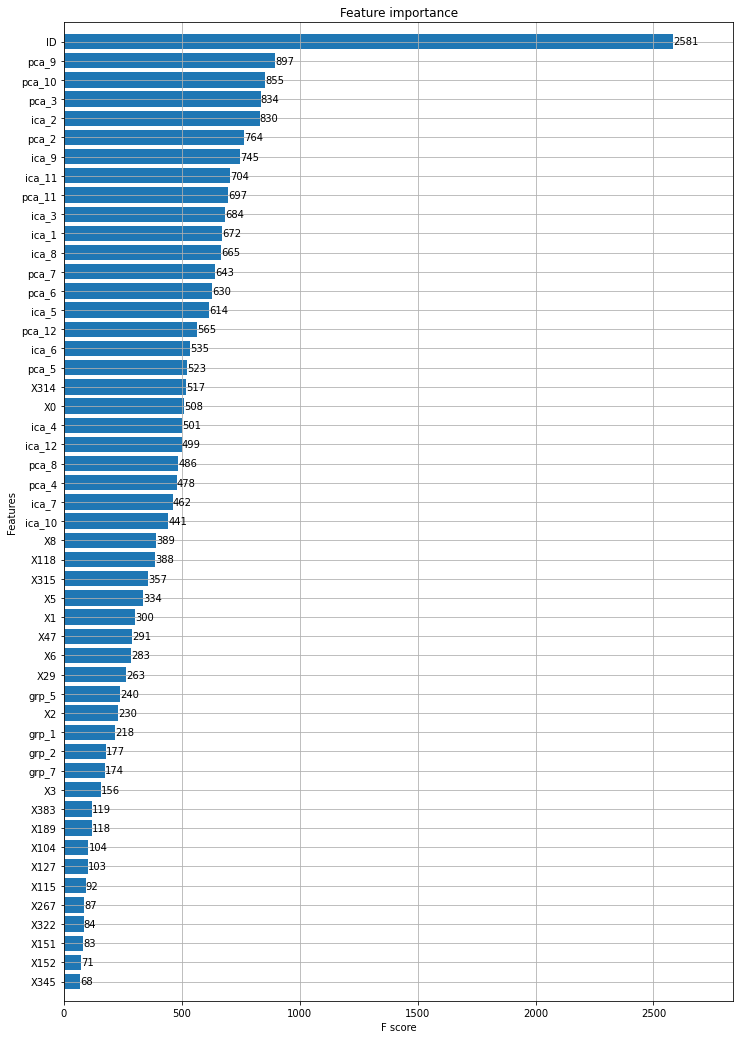

In [ ]:
fig, ax = plt.subplots(figsize = (12,18))
xgb.plot_importance(model, max_num_features=50, height = 0.8, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import r2_score

print(r2_score(dtrain.get_label(), model.predict(dtrain)))

0.7131165239962037


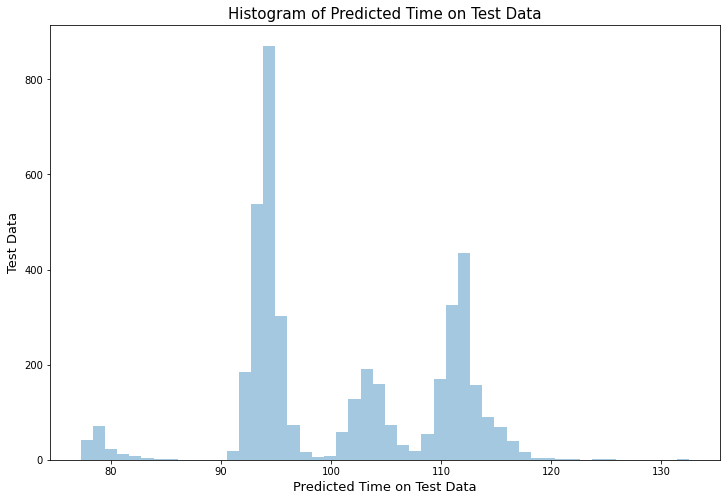

In [ ]:
y_pred = model.predict(dtest)
output = pd.DataFrame({'id' : test['ID'].astype(np.int32), 'y':y_pred})
output.to_csv('XGB_test_results.csv', index=False)
output = pd.DataFrame({'id':test['ID'].astype(np.int32), 'y':y_pred})
plt.figure(figsize=(12,8))
sns.distplot(output.y.values, bins = 50, kde= False)
plt.xlabel('Predicted Time on Test Data', fontsize = 13)
plt.ylabel('Test Data', fontsize = 13)
plt.title('Histogram of Predicted Time on Test Data', fontsize = 15)
plt.show()

# Apply Stacked Regression Model

## Create a class to combine the results of each estimator

In [ ]:
class StackingEstimator(BaseEstimator, TransformerMixin):
    def __init__(self, estimator):
        self.estimator = estimator

    def fit(self, X, y=None, **fit_params):
        self.estimator.fit(X, y, **fit_params)
        return self

    """
    1. np.hstack : 두 배열을 가로로 이어붙이는 함수
    2. predict_proba 의 출력은 각 클래스에 대한 확률
    3. issubclass(subclass, superclass) -> subclass가 superclass의 자식 클래스인지, 다시 말해 subclass가 superclass를 상속받는지 판단해 True, False 를 반환
    4. hasattr(self.estimator, 'predict_proba') -> self.estimator(우리의 머신러닝 모델) 에 'predict_proba' 라는 멤버가 있는지 판단해 True, False 를 반환
    """

    def transform(self, X):
        X = check_array(X)
        X_transformed = np.copy(X)

        if issubclass(self.estimator.__class__, ClassifierMixin) and hasattr(self.estimator, 'predict_proba'):

            # X 에 각 클래스에 대한 확률을 이어 붙여준다.
            X_transformed = np.hstack((self.estimator.predict_proba(X), X))

        # 위의 X_transformed 에 예측 클래스를 이어 붙여준다.
        X_transformed = np.hstack((np.reshape(self.estimator.predict(X), (-1, 1)), X_transformed))

        return X_transformed

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/Data/mercedes-benz-greener-manufacturing/train.csv')
test = pd.read_csv('/content/drive/MyDrive/Data/mercedes-benz-greener-manufacturing/test.csv')

print('Train shape : ', train.shape)
print('Test shape : ', test.shape)

Train shape :  (4209, 378)
Test shape :  (4209, 377)


### Label Encoding

In [ ]:
for c in train.columns:
  if train[c].dtype == 'object':
    lbl = LabelEncoder()
    lbl.fit(list(train[c].values) + list(test[c].values))
    train[c] = lbl.transform(list(train[c].values))
    test[c] = lbl.transform(list(test[c].values))

### Data Preparation

In [ ]:
train_y = train['y'].values
y_mean = np.mean(train_y)
id_test = test['ID'].values
train = train.drop(['ID'], axis = 1)
test = test.drop(['ID'], axis = 1)

def xgb_r2_score(preds, dtrain):
  lables = dtrain.get_label()
  return 'r2', r2_score(labels, preds)

usable_columns = list(set(train.columns) - set(['y']))

In [ ]:
n_comp = 15

# tSVD
tsvd = TruncatedSVD(n_components=n_comp, random_state=420)
tsvd_results_train = tsvd.fit_transform(train.drop(["y"], axis=1))
tsvd_results_test = tsvd.transform(test)
# PCA
pca = PCA(n_components=n_comp, random_state=42)
pca2_results_train = pca.fit_transform(train.drop(["y"], axis=1))
pca2_results_test = pca.transform(test)

# ICA
ica = FastICA(n_components=n_comp, random_state=42)
ica2_results_train = ica.fit_transform(train.drop(["y"], axis=1))
ica2_results_test = ica.transform(test)

# GRP
grp = GaussianRandomProjection(n_components=n_comp, eps=0.1, random_state=42)
grp_results_train = grp.fit_transform(train.drop(["y"], axis=1))
grp_results_test = grp.transform(test)

# SRP
srp = SparseRandomProjection(n_components=n_comp, dense_output=True, random_state=42)
srp_results_train = srp.fit_transform(train.drop(["y"], axis=1))
srp_results_test = srp.transform(test)

for i in range(1, n_comp+1):

    train['tsvd_' + str(i)] = tsvd_results_train[:,i-1]
    test['tsvd_' + str(i)] = tsvd_results_test[:, i-1]

    train['pca_' + str(i)] = pca2_results_train[:,i-1]
    test['pca_' + str(i)] = pca2_results_test[:, i-1]

    train['ica_' + str(i)] = ica2_results_train[:,i-1]
    test['ica_' + str(i)] = ica2_results_test[:, i-1]

    train['grp_' + str(i)] = grp_results_train[:, i-1]
    test['grp_' + str(i)] = grp_results_test[:, i-1]

    train['srp_' + str(i)] = srp_results_train[:, i-1]
    test['srp_' + str(i)] = srp_results_test[:,i-1]

In [ ]:
final_train = train[usable_columns].values
final_test = test[usable_columns].values

import xgboost as xgb

xgb_params = {
    'n_trres' : 500,
    'eta' : 0.005,
    'max_depth' : 5,
    'subsample' : 0.9,
    'objective' : 'reg:linear',
    'eval_metric' : 'rmse',
    'base_score' : y_mean,
    'silent' : 1
}

In [ ]:
dtrain = xgb.DMatrix(train.drop(['y'], axis = 1), train_y)
dtest = xgb.DMatrix(test)

In [ ]:
cv_result = xgb.cv(xgb_params, dtrain, num_boost_round=1000, verbose_eval = 50, show_stdv= False)

num_boost_rounds = len(cv_result)
print(num_boost_rounds)

[0]	train-rmse:12.6394	test-rmse:12.6385
[50]	train-rmse:11.049	test-rmse:11.1552
[100]	train-rmse:9.9098	test-rmse:10.1575
[150]	train-rmse:9.10762	test-rmse:9.50485
[200]	train-rmse:8.54574	test-rmse:9.08949
[250]	train-rmse:8.15025	test-rmse:8.82886
[300]	train-rmse:7.85935	test-rmse:8.67103
[350]	train-rmse:7.64133	test-rmse:8.57744
[400]	train-rmse:7.46815	test-rmse:8.52432
[450]	train-rmse:7.31364	test-rmse:8.50144
[500]	train-rmse:7.17089	test-rmse:8.4916
[550]	train-rmse:7.05207	test-rmse:8.48849
[600]	train-rmse:6.94969	test-rmse:8.48929
[650]	train-rmse:6.84797	test-rmse:8.49383
[700]	train-rmse:6.7476	test-rmse:8.50035
[750]	train-rmse:6.66281	test-rmse:8.50833
[800]	train-rmse:6.58419	test-rmse:8.51624
[850]	train-rmse:6.50149	test-rmse:8.5229
[900]	train-rmse:6.42552	test-rmse:8.52976
[950]	train-rmse:6.35722	test-rmse:8.53574
[999]	train-rmse:6.28754	test-rmse:8.54285
1000


In [ ]:
model = xgb.train(dict(xgb_params, silent = 0), dtrain, num_boost_round=num_boost_rounds)
y_pred = model.predict(dtest)

[08:25:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
from sklearn.pipeline import make_pipeline, make_union
Stacked_pipeline = make_pipeline(
    StackingEstimator(estimator=LassoLarsCV(normalize=True)),
    StackingEstimator(estimator=GradientBoostingRegressor(learning_rate=0.001,loss="huber",max_features=0.55,
                                                          min_samples_leaf=18,
                                                          min_samples_split=14, subsample=0.7)),
    LassoLarsCV())


Stacked_pipeline.fit(final_train, train_y)
predictions = Stacked_pipeline.predict(final_test)

In [ ]:
print('R2 score on train data : ')
print(r2_score(train_y, Stacked_pipeline.predict(final_train)*0.2855 + model.predict(dtrain)*0.7145))

sub = pd.DataFrame()
sub['Id'] = id_test
sub['y'] = y_pred*0.75 + predictions*0.25
sub.to_csv('stacked_model_pred.csv', index = False)

R2 score on train data : 
0.6820320087807696


## Feature Importances

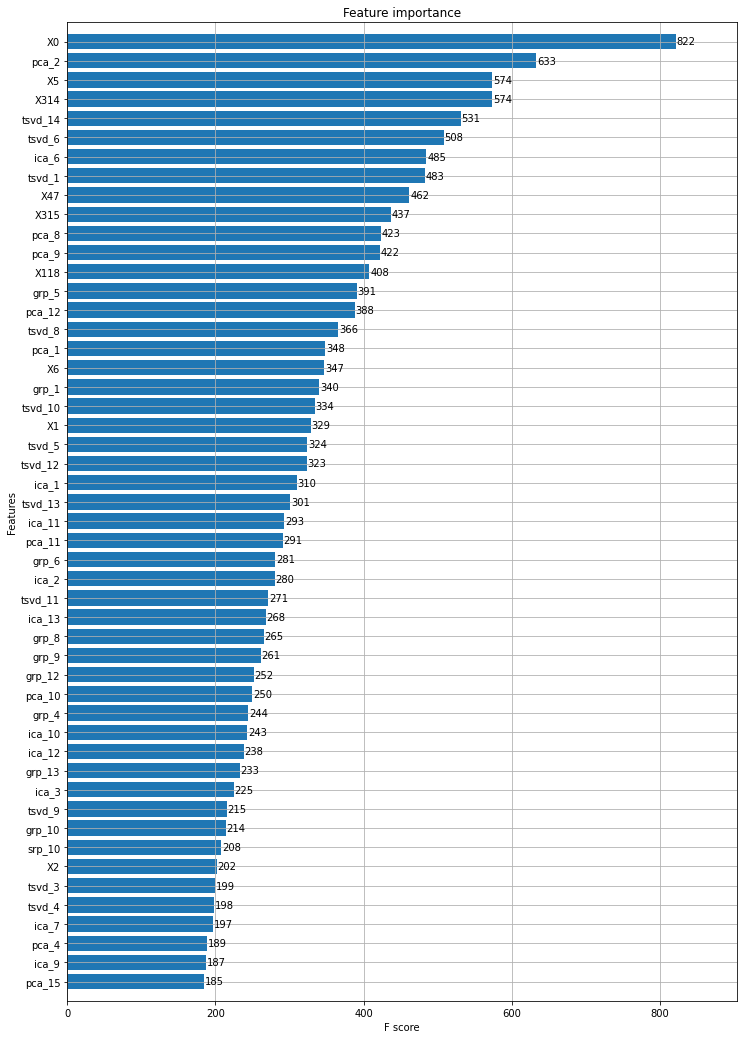

In [ ]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features = 50, height=0.8, ax=ax)
plt.show()